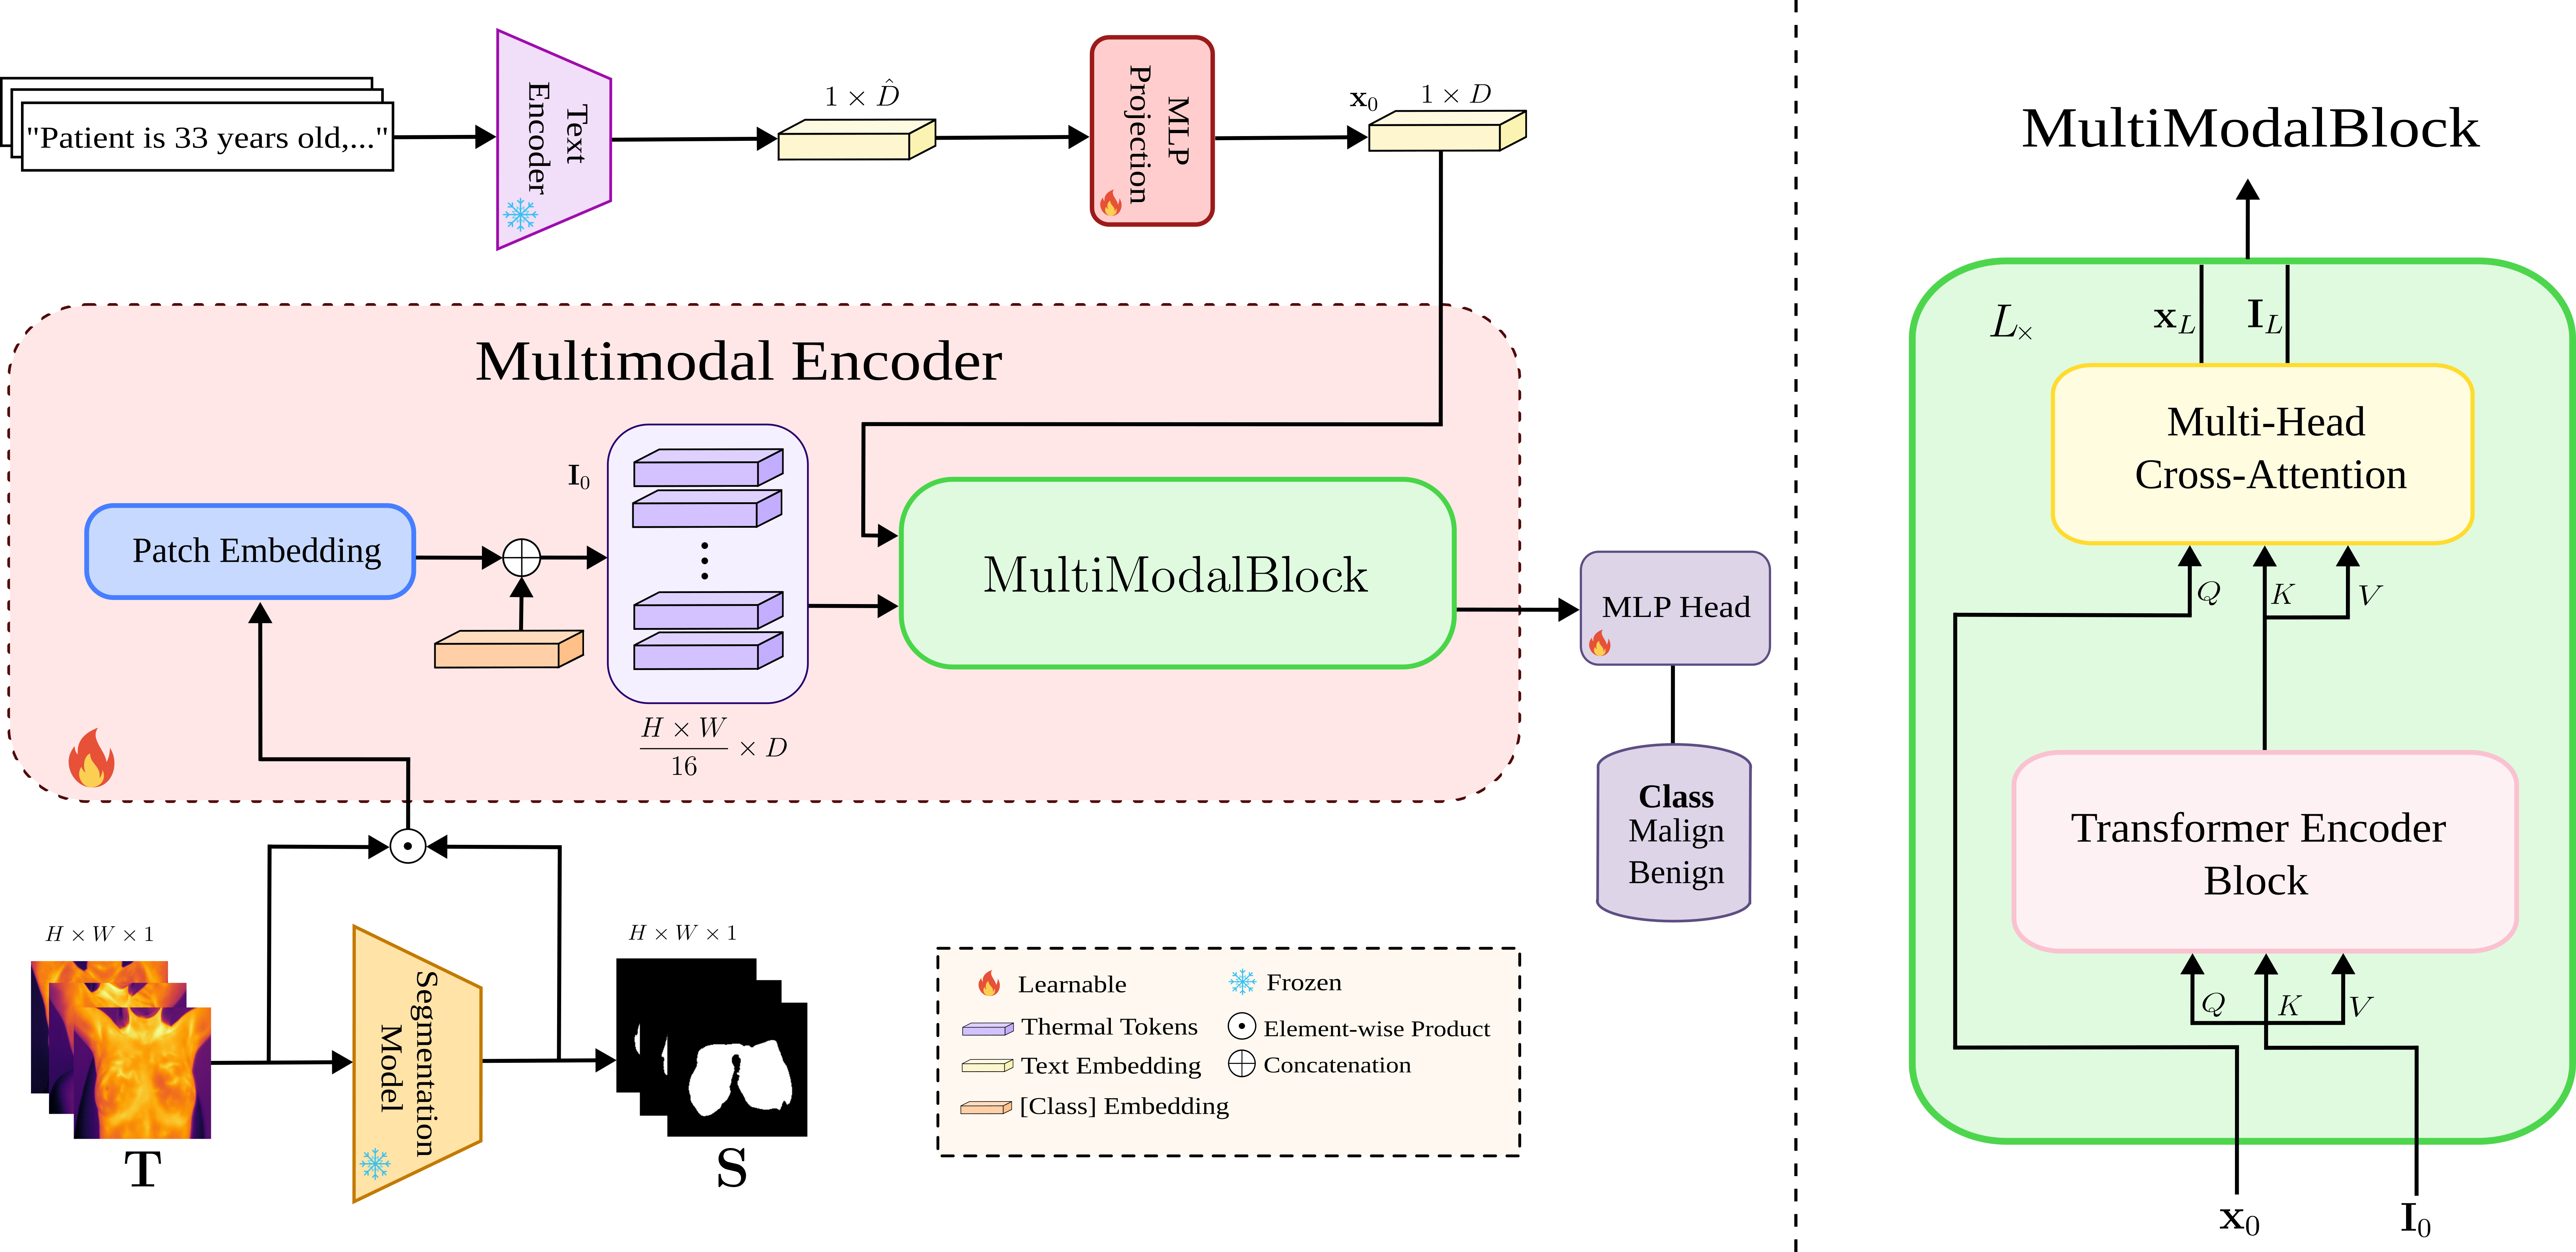

In [1]:
import os
import shutil

# 1) Define repo URL and local directory name
REPO_URL = "https://token@github.com/semilleroCV/breastcatt-commit-97752a8.git"
REPO_DIR = "breastcatt-commit-97752a8"

# 2) Delete the directory if it exists
if os.path.isdir(REPO_DIR):
    print(f"Directory '{REPO_DIR}' exists. Deleting it...")
    shutil.rmtree(REPO_DIR)

# 3) Clone the repository
print(f"Cloning repository into ./{REPO_DIR}...")
os.system(f"git clone {REPO_URL}")

# 4) Change into the repo directory
os.chdir(REPO_DIR)
print("Current working directory:", os.getcwd())

Cloning repository into ./breastcatt-commit-97752a8...
Current working directory: /content/breastcatt-commit-97752a8


In [2]:
# every time you do a factory reset you have to run this
!pip install --upgrade -r requirements.txt -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
# # RUN THIS CELL ONLY LOCALLY
# import sys
# import os

# # The notebook is in ‘notebooks/’, but the project (and `breastcatt`) is in the parent directory.
# # We add the parent directory to the path in order to import `breastcatt`.
# project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# if project_root not in sys.path:
#   sys.path.append(project_root)

In [3]:
import torch
from safetensors.torch import load_file
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Lambda
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torchmetrics.classification import BinarySpecificity
from huggingface_hub import hf_hub_download
import json

from breastcatt import tfvit

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_split(model, dataloader, device):
    """
    Evaluates the model on a given dataloader.
    """

    model.eval()
    results = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Running Inference"):
            views = batch.pop("view")
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            labels = batch["labels"]

            outputs = model(**batch)
            probs = outputs.logits.sigmoid()  # shape [B, 1]
            preds = (probs > 0.5).long().squeeze(-1)  # shape [B]

            for view, label, pred in zip(views, labels.cpu().numpy(), preds.cpu().numpy()):
                results.append({"view": view, "label": label, "prediction": pred})

    return pd.DataFrame(results)

def display_metrics(df, view_name):
    """Calculates and displays metrics for a given dataframe slice."""
    labels = df['label']
    preds = df['prediction']

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    sensitivity = recall_score(labels, preds, zero_division=0)

    spec_metric = BinarySpecificity()
    spec_metric.update(torch.tensor(preds.values), torch.tensor(labels.values))
    specificity = spec_metric.compute().item()

    print(f"--- Metrics for {view_name.upper()} view ---")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

In [5]:
from datasets import load_dataset, Image as HFImage, ClassLabel

# 1. Load your dataset and metadata
dataset = load_dataset("SemilleroCV/DMR-IR", revision="69ffd6240b4a50bc4a05c59b70773f3a506054f2",
                        token="token")
dataset = dataset.cast_column("image", HFImage(decode=False))
metadata_df = pd.read_csv("data/DMR-IR/dmr_ir_metadata_w_views.csv")  # Replace with your actual path

# 2. Create mapping dictionaries
file_to_protocol = dict(zip(metadata_df['file_name'].apply(lambda x: os.path.basename(str(x))), metadata_df['protocol']))
file_to_view = dict(zip(metadata_df['file_name'].apply(lambda x: os.path.basename(str(x))), metadata_df['view']))

# 3. Process function with proper image handling
def add_metadata(example):
    # Decode image to access filename (if needed)
    if 'file_name' not in example:
        # Decode the image bytes to get filename
        file_name = example['image']['path']
    else:
        file_name = example['file_name']

    # Add new metadata columns
    example['protocol'] = file_to_protocol.get(file_name, "Unknown")
    example['view'] = file_to_view.get(file_name, "Unknown")

    # Keep original image data (no re-encoding needed here)
    return example

dataset = dataset.map(add_metadata)
dataset = dataset.cast_column("image", HFImage(decode=True))

train_val_split = 0.15

# If we don't have a validation split, split off a percentage of train as validation.
train_val_split = None if "validation" in dataset.keys() else train_val_split
if isinstance(train_val_split, float) and train_val_split > 0.0:
    split = dataset["train"].train_test_split(train_val_split, seed=0)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

print(f"validation split size: {len(dataset['validation'])}")

Map:   0%|          | 0/5663 [00:00<?, ? examples/s]

Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

validation split size: 850


In [6]:
# --- ONLY RUN THIS CELL to Load one of our models ---
MODEL_REPO_ID = "SemilleroCV/tfvit-base-text-2" # it can be base, base-text and base-text-seg

print(f"Loading model from {MODEL_REPO_ID}...")
config_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="config.json")
try:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="pytorch_model.bin")
except:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="model.safetensors")

# Load config
with open(config_path, "r") as f:
    init_args = json.load(f)

# Init model
model = (tfvit.multimodal_vit_large_patch16(**init_args) if init_args["embed_dim"] == 1024
         else tfvit.multimodal_vit_base_patch16(**init_args))

# Load and adapt state dict
state_dict = load_file(state_dict_path, device="cpu") if state_dict_path.endswith("safetensors") \
            else torch.load(state_dict_path, map_location="cpu")

# Key renaming
state_dict = {k.replace("text_embed_proj.", "language_model.proj."): v
              for k, v in state_dict.items()}

# Load weights (ignore missing LM weights)
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)

# --- Transformations ---
min_max_norm = Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8) if x.max() > x.min() else x)
val_transforms = Compose(
    [
        Resize((224, 224)),
        ToTensor(),
        min_max_norm,
    ]
)

def preprocess_val(example_batch):
    """Apply _val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image) for image in example_batch["image"]
    ]
    return example_batch

# DataLoaders creation:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    texts = [example["text"] for example in examples]
    labels = torch.tensor([example["label"] for example in examples])

    # Get the original view names if they're encoded
    if isinstance(dataset["validation"].features["view"], ClassLabel):
        view_names = dataset["validation"].features["view"].names
        views = [view_names[example["view"]] for example in examples]  # Convert indices to names
    else:
        views = [example["view"] for example in examples]  # Already in name format

    return {"pixel_values": pixel_values, "texts": texts, "labels": labels, "view": views}

eval_dataset = dataset["validation"].with_transform(preprocess_val)

BATCH_SIZE = 512
test_dataloader = DataLoader(dataset = eval_dataset, batch_size = BATCH_SIZE,
                             shuffle = False, collate_fn = collate_fn)

results_df = evaluate_split(model, test_dataloader, DEVICE)
print()
for view_name in sorted(results_df['view'].unique()):
    view_df = results_df[results_df['view'] == view_name]
    display_metrics(view_df, view_name)

Loading model from SemilleroCV/tfvit-base-text-2...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/175 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

📥 Downloading MAE base weights from Facebook's servers...
URL: https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth
Saving to: checkpoints/fvit/mae_pretrain_vit_base.pth
Progress: 100.0%
✅ Successfully downloaded MAE base weights to: checkpoints/fvit/mae_pretrain_vit_base.pth


config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/713M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/713M [00:00<?, ?B/s]

Loading checkpoint from: checkpoints/fvit/mae_pretrain_vit_base.pth
Adapting patch_embed.proj.weight from 3 channels to 1 channel...

✅ Loaded weights: 148 layers.
❌ Not found in model: 0 layers.
📋 Details of load_state_dict:
_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'language_model.model_lm.embeddings.word_embeddings.weight', 'language_model.model_lm.embeddings.position_embeddings.weight', 'language_model.model_lm.embeddings.token_type_embeddings.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.bias', 'language_model.model_lm.encoder.layer.0.attention.self.query.weight', 'language_model.model_lm.encoder.layer.0.attention.self.query.bias', 'language_model.model_lm.encoder.layer.0.attention.self.key.weight', 'language_model.model_lm.encoder.layer.0.attention.self.key.bias', 'language_model.model_lm.encoder.layer.0.attention.self.value.weight', 'language_model.model_lm.encoder.layer.0.attention.s

Running Inference: 100%|██████████| 2/2 [00:36<00:00, 18.11s/it]


--- Metrics for FRONTAL view ---
Accuracy: 0.9954, Precision: 0.9917, Sensitivity: 0.9958, Specificity: 0.9951
--- Metrics for LEFT 45° view ---
Accuracy: 0.8966, Precision: 0.9333, Sensitivity: 0.8750, Specificity: 0.9231
--- Metrics for LEFT 90° view ---
Accuracy: 0.9552, Precision: 0.9200, Sensitivity: 0.9583, Specificity: 0.9535
--- Metrics for RIGHT 45° view ---
Accuracy: 0.9189, Precision: 0.8750, Sensitivity: 0.9333, Specificity: 0.9091
--- Metrics for RIGHT 90° view ---
Accuracy: 0.9857, Precision: 0.9565, Sensitivity: 1.0000, Specificity: 0.9792


## evaluation per view in test set

In [ ]:
# --- ONLY RUN THIS CELL to Load one of our models ---
MODEL_REPO_ID = "SemilleroCV/tfvit-base-text-2" # it can be base, base-text and base-text-seg

print(f"Loading model from {MODEL_REPO_ID}...")
config_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="config.json")
try:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="pytorch_model.bin")
except:
    state_dict_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename="model.safetensors")

# Load config
with open(config_path, "r") as f:
    init_args = json.load(f)

# Init model
model = (tfvit.multimodal_vit_large_patch16(**init_args) if init_args["embed_dim"] == 1024
         else tfvit.multimodal_vit_base_patch16(**init_args))

# Load and adapt state dict
state_dict = load_file(state_dict_path, device="cpu") if state_dict_path.endswith("safetensors") \
            else torch.load(state_dict_path, map_location="cpu")

# Key renaming
state_dict = {k.replace("text_embed_proj.", "language_model.proj."): v
              for k, v in state_dict.items()}

# Load weights (ignore missing LM weights)
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)

# --- Transformations ---
min_max_norm = Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8) if x.max() > x.min() else x)
val_transforms = Compose(
    [
        Resize((224, 224)),
        ToTensor(),
        min_max_norm,
    ]
)

def preprocess_val(example_batch):
    """Apply _val_transforms across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image) for image in example_batch["image"]
    ]
    return example_batch

# DataLoaders creation:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    texts = [example["text"] for example in examples]
    labels = torch.tensor([example["label"] for example in examples])

    # Get the original view names if they're encoded
    if isinstance(dataset["test"].features["view"], ClassLabel):
        view_names = dataset["test"].features["view"].names
        views = [view_names[example["view"]] for example in examples]  # Convert indices to names
    else:
        views = [example["view"] for example in examples]  # Already in name format

    return {"pixel_values": pixel_values, "texts": texts, "labels": labels, "view": views}

eval_dataset = dataset["test"].with_transform(preprocess_val)

BATCH_SIZE = 512
test_dataloader = DataLoader(dataset = eval_dataset, batch_size = BATCH_SIZE,
                             shuffle = False, collate_fn = collate_fn)

results_df = evaluate_split(model, test_dataloader, DEVICE)
print()
for view_name in sorted(results_df['view'].unique()):
    view_df = results_df[results_df['view'] == view_name]
    display_metrics(view_df, view_name)

Loading model from SemilleroCV/tfvit-base-text-2...
✅ MAE base weights already exist at: checkpoints/fvit/mae_pretrain_vit_base.pth
Loading checkpoint from: checkpoints/fvit/mae_pretrain_vit_base.pth
Adapting patch_embed.proj.weight from 3 channels to 1 channel...

✅ Loaded weights: 148 layers.
❌ Not found in model: 0 layers.
📋 Details of load_state_dict:
_IncompatibleKeys(missing_keys=['cls_token', 'pos_embed', 'language_model.model_lm.embeddings.word_embeddings.weight', 'language_model.model_lm.embeddings.position_embeddings.weight', 'language_model.model_lm.embeddings.token_type_embeddings.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.weight', 'language_model.model_lm.encoder.layer.0.attention.ln.bias', 'language_model.model_lm.encoder.layer.0.attention.self.query.weight', 'language_model.model_lm.encoder.layer.0.attention.self.query.bias', 'language_model.model_lm.encoder.layer.0.attention.self.key.weight', 'language_model.model_lm.encoder.layer.0.attention.self.ke

Running Inference: 100%|██████████| 3/3 [00:55<00:00, 18.55s/it]


--- Metrics for FRONTAL view ---
Accuracy: 0.8765, Precision: 0.8415, Sensitivity: 0.8214, Specificity: 0.9090
--- Metrics for LEFT 45° view ---
Accuracy: 0.8814, Precision: 0.8276, Sensitivity: 0.9231, Specificity: 0.8485
--- Metrics for LEFT 90° view ---
Accuracy: 0.8426, Precision: 0.7500, Sensitivity: 0.8462, Specificity: 0.8406
--- Metrics for RIGHT 45° view ---
Accuracy: 0.8667, Precision: 0.8214, Sensitivity: 0.8846, Specificity: 0.8529
--- Metrics for RIGHT 90° view ---
Accuracy: 0.9083, Precision: 0.8537, Sensitivity: 0.8974, Specificity: 0.9143
